# Distance Indicator

Here we create an predictor that is defined as the geographic (as the crow flies) distance between The Bachelor's hometown and each contestant

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import json
from geopy import geocoders
import math

In [3]:
#Import seasonsDict.json which contains hometown information
with open("tempdata/listAllDicts.json") as json_file:
    seasons = json.load(json_file)


Here get the hometown information from each candidate

In [4]:
#Make a function that get's contestant's hometown for a given season
#Update known errors in the dictionary
def get_hometowns(choose_season):
    town_dict = {}
    for idict in seasons:
        if idict["season"] == choose_season:
            if idict["elimination"] == "bachelor":
                bachtown = idict["hometown"]
            else:
                if idict["name"] == "Kacie Boguskie":
                    idict["hometown"] = "Clarksville, Tennessee"
                town_dict.update({idict['name']:idict['hometown']})
    return bachtown, town_dict


We use a function that computes the distance between two points on a sphere, which follows the following equation:

$$ \cos(arc length) = \cos{\phi_1}\cos{\phi_2} + \sin{\phi_1}\sin{\phi_2}\cos{(\theta_1 - \theta_2)}$$

We then multiply the arc length by the radius of the Earth to get the distance.

In [5]:
#Create a function to compute distance between two lat/lon points on Earth
#Borrows heavily from http://www.johndcook.com/blog/python_longitude_latitude/ 
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    
    Rearth = 3959 #in miles
 
    return arc * Rearth

To convert hometowns in (city, state) format, we use the python package "geopy" which accepts input in our format, and returns the lat/lon coordinates of the center of town. 

In [6]:
def get_contest_distance(hometown_output):
    bach_home, c_home = hometown_output
    
    #Use geopy package to get lat/lon from location
    gn = geocoders.Nominatim()
    
    #Get the Bachelor location
    bhome = gn.geocode(bach_home)
    blat = float(bhome.raw["lat"])
    blon = float(bhome.raw["lon"])

    #Find distance between bachelor and contestant distances
    distance_dict = {}
    grid_dict = {}
    for contestant in c_home.keys():
        chome = gn.geocode(c_home[contestant])
        clat = float(chome.raw["lat"])
        clon = float(chome.raw["lon"])

        #Find distance
        distance_apart = distance_on_unit_sphere(blat, blon, clat, clon)
        distance_dict.update({contestant: distance_apart})
        
        #Save lat/lon
        grid_dict.update({contestant: (clat,clon)})

    return distance_dict, grid_dict
    

Run over all seasons and save the output as a dictionary

In [7]:
season_nums = range(13,20)

#Run over all seasons
distance_dict = {}
for season_num in season_nums:
    distance_dict.update({season_num: get_contest_distance(get_hometowns(season_num))[0]})
    print "season ", season_num, " done"
    

#Run again to get lat/lon for visualization
season_nums = range(13,20)

#Run over all seasons
grid_dict = {}
for season_num in season_nums:
    grid_dict.update({season_num: get_contest_distance(get_hometowns(season_num))[1]})
    print "season ", season_num, " done"
    
with open('grid_dict.json', 'w') as fp:
    json.dump(grid_dict, fp)


season  13  done
season  14  done
season  15  done
season  16  done
season  17  done
season  18  done
season  19  done
season  13  done
season  14  done
season  15  done
season  16  done
season  17  done
season  18  done
season  19  done


In [8]:
with open('distances.json', 'w') as fp:
    json.dump(distance_dict, fp)

In [9]:
from mpl_toolkits.basemap import Basemap

# Make a function that maps hometowns and draws a line from Bachelor hometown to 
# winner hometown.  Processes one Season at a time.
#
# NOTE: Only maps continental US, because there are no contestants/bachelors from HI, Alaska, etc.
#
# Input:
#     hometown      = get_hometown() output (bach hometown and dict of contestant hometowns)
#     subplotNum    = position on grid of plots
#     winnerTownNum = index of 'winnertowns' array (array of winners' hometowns)
#     seasonNum     = season number 

def make_maps(hometown_output, subplotNum, winnerTownNum, seasonNum):
    #Get Bachelor hometown, dict of Contestant hometowns for this season
    bachelor_home, contestant_home = hometown_output
    
    #Add a new subplot of USA to the grid
    ax=fig.add_subplot(subplotNum)
    m = Basemap(projection='merc',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-127,urcrnrlon=-65,lat_ts=20,resolution='c')
    m.drawmapboundary(fill_color='none')
    m.drawcoastlines()
    m.drawcountries()
    
    #Use geopy package to get lat/lon from location
    gn = geocoders.Nominatim()
    
    #Get the Bachelor location
    bachHome = gn.geocode(bachelor_home, timeout=120)
    bachLat = float(bachHome.raw["lat"])
    bachLon = float(bachHome.raw["lon"])
    
    #Put a big blue circle on Bachelor's hometown
    x,y = m(bachLon, bachLat)
    m.plot(x,y, color='blue', marker='o') # label='Bachelor')

    #For each contestant in this season, 
    for contestant in contestant_home.keys():
        #get coordinates of hometowns
        contHome = gn.geocode(contestant_home[contestant], timeout=120)
        contLat = float(contHome.raw["lat"])
        contLon = float(contHome.raw["lon"])
    
        #put a light blue dot on Contestant's hometown
        xpt,ypt = m(contLon, contLat)
        m.plot(xpt, ypt, color='lightskyblue', marker='.') #, label='Ladies')
        
    #Put a red star on winner's hometown
    winnerHome = gn.geocode(winnertowns[winnerTownNum], timeout=120)
    winnerLat = float(winnerHome.raw["lat"])
    winnerLon = float(winnerHome.raw["lon"])
    wx,wy = m(winnerLon, winnerLat)
    m.plot(wx, wy, color='red', marker='*') # label='Winner')

    #Draw red line from Bachelor hometown to Winner hometown
    m.drawgreatcircle(bachLon, bachLat, winnerLon, winnerLat, linewidth=2, color='red')
    ax.set_title('Season ' + `seasonNum`)
    

//anaconda/lib/python2.7/site-packages/matplotlib/legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


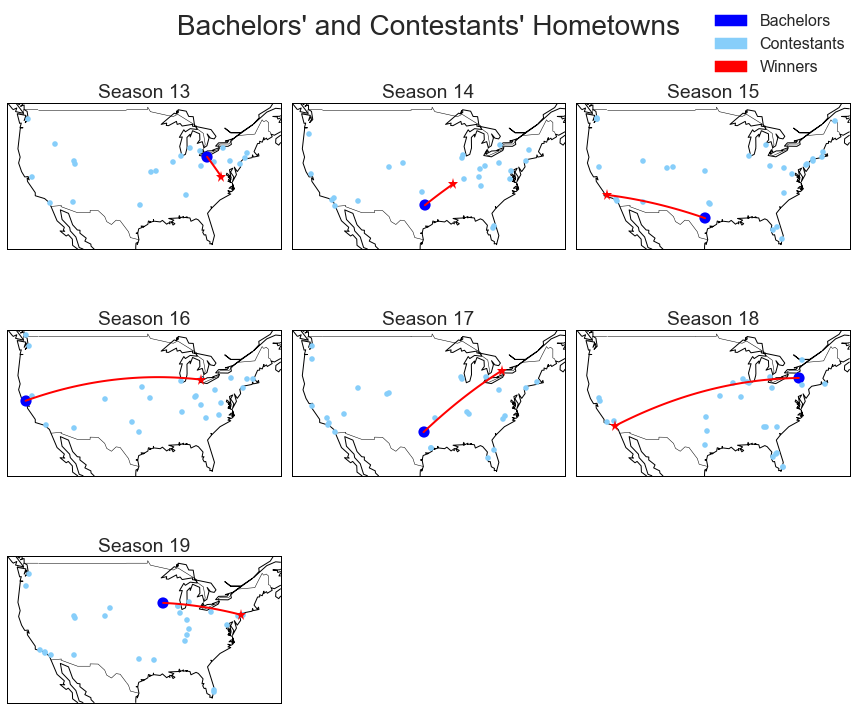

In [10]:
import matplotlib.patches as mpatches

#Make Array of winners' hometowns
winnertowns = []
for sdict in seasons:
    if sdict["elimination"] == "bachelor":
        winnertowns.append(sdict["hometown"])

#Set up plot figure and variables 
fig = plt.figure(figsize=(12,11))  
subplotNum = 331                   #3=numrows, 3=numcols, 1=starting axis to use
winnerTownNum = 0                  #index in array of winners' hometowns

#Add plots for each season
season_nums = range(13,20)
for seasonNum in season_nums:      #for each season,
    #add a plot to the grid
    make_maps(get_hometowns(seasonNum), subplotNum, winnerTownNum, seasonNum) 
    subplotNum += 1                #go to next plot position on grid
    winnerTownNum += 1             #get next Winner hometown name from array
    
#Add title for whole grid
fig.suptitle("Bachelors' and Contestants' Hometowns", fontsize=28 ) 

#Make and add a legend
blue_patch = mpatches.Patch(color='blue',label='Bachelor')
lightblue_patch = mpatches.Patch(color='lightskyblue',label='Contestants')
red_patch = mpatches.Patch(color='red',label='Winner')
fig.legend((blue_patch, lightblue_patch, red_patch), ('Bachelors', 'Contestants', 'Winners'), 'best') #, shadow=True, fontsize=24) #loc=2, bbox_to_anchor=(1.05,1), fancybox=True, ncol=1, shadow=True, fontsize=18)

#Set figure to tight layout, use 'rect' so that suptitle is above grid of plots
fig.tight_layout(rect=[0,0.03,1,0.95])